In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
df = pd.read_csv("rap_df.csv").drop('Unnamed: 0', axis=1)
df.head()

,danceability,energy,loudness,musical_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,explicit,popular,duration_per_num_sections,key__1,key__2,key__3,key__4,key__5,key__6,key__7,key__8,key__9,key__10,key__11,time_sig__1,time_sig__3,time_sig__4,time_sig__5,no_instruments
0,0.320,0.934,-4.363,0,0.246,0.13400,0.000000,0.0925,0.495,138.982,196476,0,0,21830.666667,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,0.282,0.579,-12.653,0,0.380,0.05240,0.000812,0.0977,0.205,178.866,386556,0,0,20345.052632,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0.548,0.724,-6.681,0,0.275,0.39000,0.000000,0.4690,0.481,110.066,516000,1,0,25800.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,0.735,0.890,-4.886,0,0.252,0.14800,0.000000,0.3140,0.565,122.014,572547,1,0,28627.350000,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,0.713,0.883,-5.407,0,0.265,0.00588,0.000020,0.7240,0.452,124.967,338627,1,0,19919.235294,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


#### Recal the class imbalance and decide how to address
- I do not intend to use SMOTE. This artificially creates songs, and I don't want to artificially create songs that are considered popular. I do not believe a machine can accurately replicate a good song by simply using KNN to create new observations.
- I will likely use both upsampling and class weight = balanced as means to address class imbalance

### Create feature and target data, scaled and unscaled

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import StandardScaler

In [4]:
X = df.drop('popular', axis=1)
y = df.popular

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Create upsampled feature and target data, scaled and unscaled

In [7]:
from sklearn.utils import resample

In [8]:
popular = df[df.popular == 1]
not_popular = df[df.popular == 0]

In [9]:
popular_upsampled = resample(popular,
                          replace=True, # sample with replacement
                          n_samples=len(not_popular), # match number in majority class
                          random_state=42) 

In [10]:
upsampled = pd.concat([not_popular, popular_upsampled])
upsampled.popular.value_counts()

1    771
0    771
Name: popular, dtype: int64

In [11]:
X_upsampled = upsampled.drop('popular', axis=1)
y_upsampled = upsampled.popular

In [12]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_upsampled, 
                                                                y_upsampled, test_size=0.20, random_state=42)

In [13]:
scaler = StandardScaler()
X_train_up_scaled = scaler.fit_transform(X_train_up)
X_test_up_scaled = scaler.transform(X_test_up)

### Make a quick function to print accuracy, f1, recall, precision

In [14]:
def print_score(y_test, y_pred):
    
    a = accuracy_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    return {'accuracy': a, "f1": f, 'recall': r, 'precision': p}


### Try a LogReg Gridsearch

In [15]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

#### Upsampled

In [82]:
upsampled_lr = LogisticRegressionCV(solver='liblinear', cv=10, penalty='l1', Cs = [.001,.01,.1,1,10,100], 
                                    max_iter=10000, verbose=True, n_jobs=-1, scoring='f1')

In [83]:
upsampled_lr.fit(X_train_up_scaled, y_train_up)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100], cv=10, max_iter=10000,
                     n_jobs=-1, penalty='l1', scoring='f1', solver='liblinear',
                     verbose=True)

In [84]:
upsampled_lr.C_

array([1.])

In [85]:
pred = upsampled_lr.predict(X_test_up_scaled)
result = print_score(y_test_up, pred)
results = {'upsampled_lr': result}
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957}}

In [86]:
print(confusion_matrix(y_test_up, pred))
print('---------------------------')
print(classification_report(y_test_up, pred))


[[ 89  68]
 [ 36 116]]
---------------------------
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       157
           1       0.63      0.76      0.69       152

    accuracy                           0.66       309
   macro avg       0.67      0.67      0.66       309
weighted avg       0.67      0.66      0.66       309



In [87]:
#print(lr_clf_weighted.coef_.reshape(29))
#print(X.columns)
features_coefs = zip(X.columns, upsampled_lr.coef_.reshape(29))
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')

In [88]:
for_bar = pd.concat([coefs_df.head(20), coefs_df.tail(5)]) #Non-zero coefficients

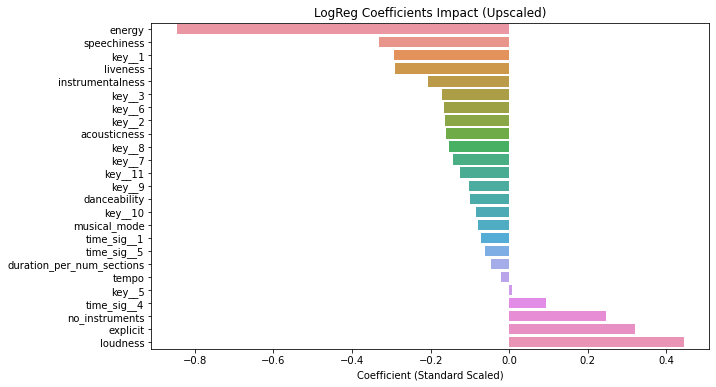

In [89]:
plt.figure(figsize=(10,6))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('LogReg Coefficients Impact (Upscaled)')
plt.xlabel('Coefficient (Standard Scaled)')
plt.ylabel('')
plt.savefig("pics/logreg_coefs_impact.png")

I am optimizing for f1 score. Unlike industries such as healthcare or predicting credit card fraud, I do not believe that recall / precision importance far outweighs the other. If we have a high recall, then we did well in the sense that our model predicts popular songs well out of all songs that should be popular. This is important -- we do not want to miss label songs that truly are popular. If we have high precision, than of all the songs we predicted to be true, X% turned out to actually be true. While in my opinion less important than recall, I think this is not something to be pushed aside. Hence, I will optimize for f1.

From the above model, the best result from logistic upscaled regression utilized unscaled (scaled resulted in roughly the same but slightly worse -- 89 in the true negative instead of 90). However, for the sake of a chart to show coefficients, I will use the scaled data.

76% recall is not bad, but I will continue trying other models as the notebook progresses.

#### Weighted

In [24]:
lr_clf_weighted = LogisticRegressionCV(solver='liblinear', class_weight='balanced', Cs = [.001,.01,.1,1,10,100],
                                      cv=10, penalty='l1', scoring = 'f1', max_iter=10000,
                                       verbose=True, n_jobs=-1)

In [25]:
lr_clf_weighted.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100], class_weight='balanced',
                     cv=10, max_iter=10000, n_jobs=-1, penalty='l1',
                     scoring='f1', solver='liblinear', verbose=True)

In [26]:
lr_clf_weighted.C_

array([0.1])

In [27]:
pred = lr_clf_weighted.predict(X_test_scaled)
result = print_score(y_test, pred)
results['lr_clf_weighted'] = result
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957},
 'lr_clf_weighted': {'accuracy': 0.6302521008403361,
  'f1': 0.5925925925925926,
  'recall': 0.810126582278481,
  'precision': 0.46715328467153283}}

In [28]:
print(confusion_matrix(y_test, pred))
print('---------------------------')
print(classification_report(y_test, pred))

[[86 73]
 [15 64]]
---------------------------
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       159
           1       0.47      0.81      0.59        79

    accuracy                           0.63       238
   macro avg       0.66      0.68      0.63       238
weighted avg       0.72      0.63      0.64       238



In [29]:
#print(lr_clf_weighted.coef_.reshape(29))
#print(X.columns)
features_coefs = zip(X.columns, lr_clf_weighted.coef_.reshape(29))
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')

In [30]:
for_bar = pd.concat([coefs_df.head(11), coefs_df.tail(7)]) ## Non-zero coefficients

Text(0, 0.5, '')

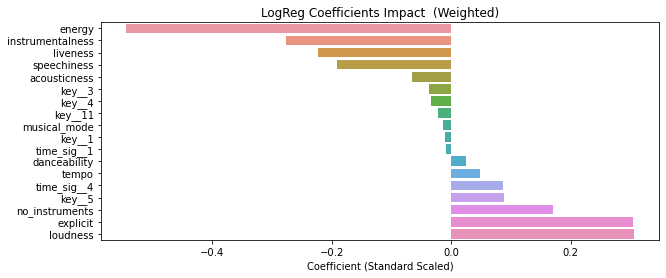

In [31]:
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('LogReg Coefficients Impact  (Weighted)')
plt.xlabel('Coefficient (Standard Scaled)')
plt.ylabel('')

Precision suffered a lot in this model, and accuracy went down as well. However, Recall is our best yet. I probably prefer the first model to this one due to the f1 score.

### Try a Pruned Decision Tree on Upsampled Data

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV

In [33]:
decision_tree = DecisionTreeClassifier()
# creating our parameters to test
# note these values have been iterrated through multiple times and this cell represents the final state
param_dict={'max_depth': [8,9,10,11],
            'min_samples_leaf' : [1,2],
            'criterion': ['gini'], 
            'min_samples_split' : [6,7,8],
            'max_features': [8,9,10]}

In [34]:
#create the instance of GridSearchCV using the recall metric for our scoring. 
grid_tree=GridSearchCV(decision_tree, param_dict, cv=10, scoring='f1', n_jobs=-1, verbose=1)
#fit the Gridsearch to our data
grid_tree.fit(X_train_up ,y_train_up)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    1.8s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [8, 9, 10, 11],
                         'max_features': [8, 9, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [6, 7, 8]},
             scoring='f1', verbose=1)

In [35]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

0.7575244684059974
{'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}
DecisionTreeClassifier(max_depth=10, max_features=10, min_samples_leaf=2,
                       min_samples_split=6)


In [36]:
pred = grid_tree.best_estimator_.predict(X_test_up)
result = print_score(y_test_up, pred)
results['decision_tree_upscaled'] = result
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957},
 'lr_clf_weighted': {'accuracy': 0.6302521008403361,
  'f1': 0.5925925925925926,
  'recall': 0.810126582278481,
  'precision': 0.46715328467153283},
 'decision_tree_upscaled': {'accuracy': 0.7313915857605178,
  'f1': 0.764872521246459,
  'recall': 0.8881578947368421,
  'precision': 0.6716417910447762}}

In [37]:
print(confusion_matrix(y_test_up, pred))
print('---------------------------')
print(classification_report(y_test_up, pred))

[[ 91  66]
 [ 17 135]]
---------------------------
              precision    recall  f1-score   support

           0       0.84      0.58      0.69       157
           1       0.67      0.89      0.76       152

    accuracy                           0.73       309
   macro avg       0.76      0.73      0.73       309
weighted avg       0.76      0.73      0.73       309



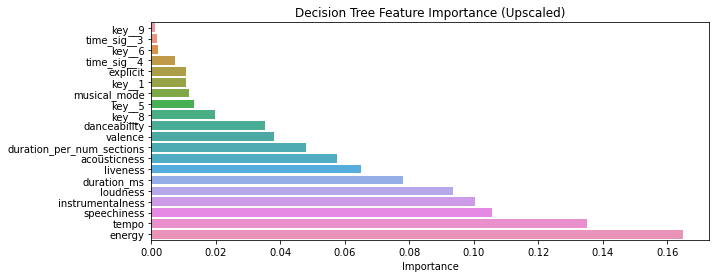

In [80]:
features_coefs = zip(X.columns, grid_tree.best_estimator_.feature_importances_)
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')
for_bar = coefs_df[coefs_df.coef != 0]## Non-zero coefficients
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('Decision Tree Feature Importance (Upscaled)')
plt.xlabel('Importance')
plt.ylabel('')
plt.savefig("pics/decision_tree_feature_imp.png")

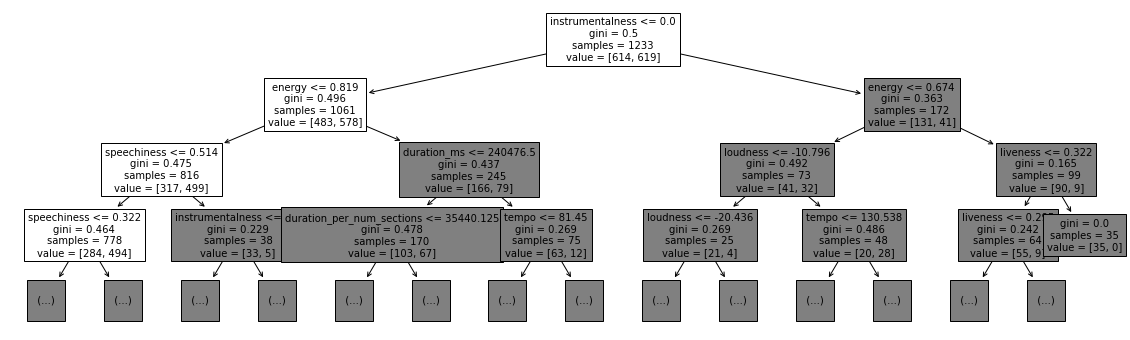

In [41]:
# Decision tree is huge so we can't nicely visualize it all, but the below it just to get an idea of the 
# first few layers
plt.figure(figsize=(20,6))
plot_tree(grid_tree.best_estimator_, max_depth=3, fontsize=10, feature_names=X.columns)
plt.show()

From every metric, this is our best model yet. It makes sense since our dataset has some noisy data (trees perform well here), as seen in the histograms from the EDA notebook.

I will try a decision tree using weighted data next, to see if that is any better.

### Try a Pruned Decision Tree on Weighted Data

In [42]:
decision_tree = DecisionTreeClassifier()
# creating our parameters to test
# note these values have been iterrated through multiple times and this cell represents the final state
param_dict={'max_depth': np.arange(0,4,1),
            'min_samples_leaf' : np.arange(0,8,1),
            'criterion': ['gini', 'entropy'], 
            'min_samples_split' : np.arange(8,16,1),
            'class_weight': ['balanced'],
            'max_features': np.arange(0,9,1)}

In [43]:
#create the instance of GridSearchCV using the recall metric for our scoring. 
grid_tree2=GridSearchCV(decision_tree, param_dict, cv=10, scoring='f1', n_jobs=-1, verbose=1)
#fit the Gridsearch to our data
grid_tree2.fit(X_train_scaled ,y_train)

Fitting 10 folds for each of 4608 candidates, totalling 46080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 11248 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 43248 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 46080 out of 46080 | elapsed:   25.5s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([0, 1, 2, 3]),
                         'max_features': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
                         'min_samples_leaf': array([0, 1, 2, 3, 4, 5, 6, 7]),
                         'min_samples_split': array([ 8,  9, 10, 11, 12, 13, 14, 15])},
             scoring='f1', verbose=1)

In [44]:
print(grid_tree2.best_score_)
print(grid_tree2.best_params_)
print(grid_tree2.best_estimator_)

0.5885364870110161
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 4, 'min_samples_split': 10}
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features=6, min_samples_leaf=4,
                       min_samples_split=10)


In [45]:
pred = grid_tree2.best_estimator_.predict(X_test_scaled)
result = print_score(y_test, pred)
results['decision_tree_weighted'] = result
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957},
 'lr_clf_weighted': {'accuracy': 0.6302521008403361,
  'f1': 0.5925925925925926,
  'recall': 0.810126582278481,
  'precision': 0.46715328467153283},
 'decision_tree_upscaled': {'accuracy': 0.7313915857605178,
  'f1': 0.764872521246459,
  'recall': 0.8881578947368421,
  'precision': 0.6716417910447762},
 'decision_tree_weighted': {'accuracy': 0.5462184873949579,
  'f1': 0.5537190082644629,
  'recall': 0.8481012658227848,
  'precision': 0.4110429447852761}}

In [46]:
print(confusion_matrix(y_test, pred))
print('---------------------------')
print(classification_report(y_test, pred))

[[63 96]
 [12 67]]
---------------------------
              precision    recall  f1-score   support

           0       0.84      0.40      0.54       159
           1       0.41      0.85      0.55        79

    accuracy                           0.55       238
   macro avg       0.63      0.62      0.55       238
weighted avg       0.70      0.55      0.54       238



I am not even going to bother printing out a chart of important features or the first few levels of a tree. This tree performed far worse than the upscaled one. Balancing by class weights does not appear to be effective for this dataset.

### Try a Random Forest Using Upscaled Data

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
#create a dictionary of all the parameters you want to tune
# note i ran through this a couple times, starting with a lot more options and honed in, so this represents 
# the last run where I was sure params were optimized
param_grid = { 
    'n_estimators': [300],
    'criterion': ['gini'],
    'max_depth': [22],
    'max_features': [5,6],
    'min_samples_split': [4],
    'min_samples_leaf': [1]
}

In [70]:
grid_forest=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_forest.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [22],
                         'max_features': [5, 6], 'min_samples_leaf': [1],
                         'min_samples_split': [4], 'n_estimators': [300]},
             scoring='f1', verbose=1)

In [71]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)

0.8182923404637025
{'criterion': 'gini', 'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
RandomForestClassifier(max_depth=22, max_features=5, min_samples_split=4,
                       n_estimators=300)


In [72]:
pred = grid_forest.best_estimator_.predict(X_test_up)
result = print_score(y_test_up, pred)
results['random_forest_up'] = result
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957},
 'lr_clf_weighted': {'accuracy': 0.6302521008403361,
  'f1': 0.5925925925925926,
  'recall': 0.810126582278481,
  'precision': 0.46715328467153283},
 'decision_tree_upscaled': {'accuracy': 0.7313915857605178,
  'f1': 0.764872521246459,
  'recall': 0.8881578947368421,
  'precision': 0.6716417910447762},
 'decision_tree_weighted': {'accuracy': 0.5462184873949579,
  'f1': 0.5537190082644629,
  'recall': 0.8481012658227848,
  'precision': 0.4110429447852761},
 'random_forest_up': {'accuracy': 0.8122977346278317,
  'f1': 0.81875,
  'recall': 0.8618421052631579,
  'precision': 0.7797619047619048},
 'xgboost': {'accuracy': 0.7864077669902912,
  'f1': 0.798780487804878,
  'recall': 0.8618421052631579,
  'precision': 0.7443181818181818},
 'voting': {'accuracy': 0.7993527508090615,
  'f1': 0.8098159509202454,
  'recall': 0.868421052631579,
  'precision

After tuning this random forest by updating the param grid multiple times to hone in on the best model, I have landed at what I think is the best random forest possible given my data. The scores are incredible. Very happy with this score. Also, random forest is the only model thus far to increase precision without losing scores in recall (hence the high f1). This data set was a little noisy, which explains the success of tree algorithms. Random forest outperforming decision tree makes sense given that it is an ensemble than generally outperforms a single model (at the sake of interpreting it though)

Will try XGBoost below, and then finally a voting classifier with all my models

In [90]:
grid_forest.best_estimator_.feature_importances_

array([0.08603323, 0.11986804, 0.08090394, 0.01076539, 0.08801021,
       0.07763327, 0.04544699, 0.08743242, 0.07873296, 0.06637006,
       0.07390029, 0.01883363, 0.07300669, 0.00939133, 0.00637885,
       0.00453048, 0.00617723, 0.00438989, 0.00688902, 0.00656194,
       0.00687196, 0.00655447, 0.00580886, 0.00425339, 0.00079737,
       0.00450851, 0.00537179, 0.00197863, 0.01259917])

Text(0, 0.5, '')

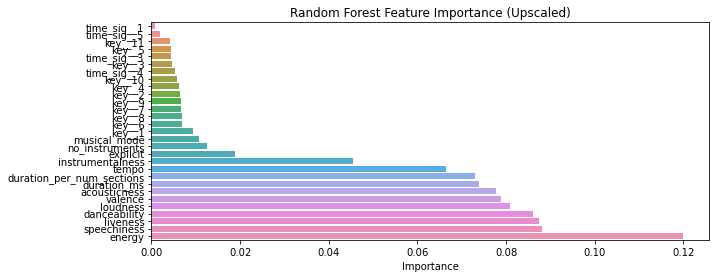

In [91]:
features_coefs = zip(X.columns, grid_forest.best_estimator_.feature_importances_)
coefs_df = pd.DataFrame(features_coefs, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')
for_bar = coefs_df[coefs_df.coef != 0]## Non-zero coefficients
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=for_bar)
plt.title('Random Forest Feature Importance (Upscaled)')
plt.xlabel('Importance')
plt.ylabel('')
#plt.savefig("pics/decision_tree_feature_imp.png")

### Try an XGBoost

In [52]:
import xgboost as xgb

In [53]:
# RUN A BASELINE XGB
xg = xgb.XGBClassifier()
xg.fit(X_train_up_scaled, y_train_up)
test_preds = xg.predict(X_test_up_scaled)
result = print_score(y_test_up, test_preds)
result

{'accuracy': 0.7637540453074434,
 'f1': 0.7833827893175075,
 'recall': 0.868421052631579,
 'precision': 0.7135135135135136}

In [54]:
# TUNE IT
param_grid = {
    "learning_rate": [0.1],
    'min_child_weight': [5],
    'subsample': [.9],
    'n_estimators': [200],
    'criterion': ['gini'],
    'max_depth': [15],
    'max_features': [2,3],
    'min_samples_split': [1],
    'min_samples_leaf': [1]
}

In [55]:
grid_xg = GridSearchCV(xgb.XGBClassifier(), param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_xg.fit(X_train_up_scaled, y_train_up)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


[15:33:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { criterion, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [56]:
print(grid_xg.best_params_)

{'criterion': 'gini', 'learning_rate': 0.1, 'max_depth': 15, 'max_features': 2, 'min_child_weight': 5, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 200, 'subsample': 0.9}


In [57]:
pred = grid_xg.best_estimator_.predict(X_test_up_scaled)
result = print_score(y_test_up, pred)
results['xgboost'] = result
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957},
 'lr_clf_weighted': {'accuracy': 0.6302521008403361,
  'f1': 0.5925925925925926,
  'recall': 0.810126582278481,
  'precision': 0.46715328467153283},
 'decision_tree_upscaled': {'accuracy': 0.7313915857605178,
  'f1': 0.764872521246459,
  'recall': 0.8881578947368421,
  'precision': 0.6716417910447762},
 'decision_tree_weighted': {'accuracy': 0.5462184873949579,
  'f1': 0.5537190082644629,
  'recall': 0.8481012658227848,
  'precision': 0.4110429447852761},
 'random_forest_up': {'accuracy': 0.8122977346278317,
  'f1': 0.8176100628930818,
  'recall': 0.8552631578947368,
  'precision': 0.7831325301204819},
 'xgboost': {'accuracy': 0.7864077669902912,
  'f1': 0.798780487804878,
  'recall': 0.8618421052631579,
  'precision': 0.7443181818181818}}

I am sure there are ways to tune this better, this isn't even my best, but I can't seem to get in the ballpark of the random forest which is currently my best model. Interesting to note this has the best recall score

I am going to try an ensemble voting classifier below to see if that beats the random forest.

### Try a Voting Classifier

In [58]:
from sklearn.ensemble import VotingClassifier

In [59]:
forest = RandomForestClassifier()

In [60]:
voting_clf = VotingClassifier(
                estimators=[('logreg', upsampled_lr), ('decisiontree', grid_tree.best_estimator_), 
                            ('forest', grid_forest.best_estimator_), ('xgboost', grid_xg.best_estimator_),
                           ('forest2', forest)],
                voting='hard', verbose=1, n_jobs= -1)
voting_clf.fit(X_train_up, y_train_up)


VotingClassifier(estimators=[('logreg',
                              LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10,
                                                       100],
                                                   cv=10, max_iter=10000,
                                                   n_jobs=-1, penalty='l1',
                                                   scoring='f1',
                                                   solver='liblinear',
                                                   verbose=True)),
                             ('decisiontree',
                              DecisionTreeClassifier(max_depth=10,
                                                     max_features=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=6)),
                             ('forest',
                              RandomForestClassifier(max_depth=21,
                           

In [73]:
pred = voting_clf.predict(X_test_up)
result = print_score(y_test_up, pred)
results['voting'] = result
results

{'upsampled_lr': {'accuracy': 0.6634304207119741,
  'f1': 0.6904761904761905,
  'recall': 0.7631578947368421,
  'precision': 0.6304347826086957},
 'lr_clf_weighted': {'accuracy': 0.6302521008403361,
  'f1': 0.5925925925925926,
  'recall': 0.810126582278481,
  'precision': 0.46715328467153283},
 'decision_tree_upscaled': {'accuracy': 0.7313915857605178,
  'f1': 0.764872521246459,
  'recall': 0.8881578947368421,
  'precision': 0.6716417910447762},
 'decision_tree_weighted': {'accuracy': 0.5462184873949579,
  'f1': 0.5537190082644629,
  'recall': 0.8481012658227848,
  'precision': 0.4110429447852761},
 'random_forest_up': {'accuracy': 0.8122977346278317,
  'f1': 0.81875,
  'recall': 0.8618421052631579,
  'precision': 0.7797619047619048},
 'xgboost': {'accuracy': 0.7864077669902912,
  'f1': 0.798780487804878,
  'recall': 0.8618421052631579,
  'precision': 0.7443181818181818},
 'voting': {'accuracy': 0.7993527508090615,
  'f1': 0.8098159509202454,
  'recall': 0.868421052631579,
  'precision

The voting classifier and the tuned random forest are neck and neck and my crowned winners, I will pickle both of these for potential later use.

In [74]:
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['model', 'accuracy', 'f1', 'recall', 'precision']


In [75]:
results_df

,model,accuracy,f1,recall,precision
0,upsampled_lr,0.663430,0.690476,0.763158,0.630435
1,lr_clf_weighted,0.630252,0.592593,0.810127,0.467153
2,decision_tree_upscaled,0.731392,0.764873,0.888158,0.671642
3,decision_tree_weighted,0.546218,0.553719,0.848101,0.411043
4,random_forest_up,0.812298,0.818750,0.861842,0.779762
5,xgboost,0.786408,0.798780,0.861842,0.744318
6,voting,0.799353,0.809816,0.868421,0.758621


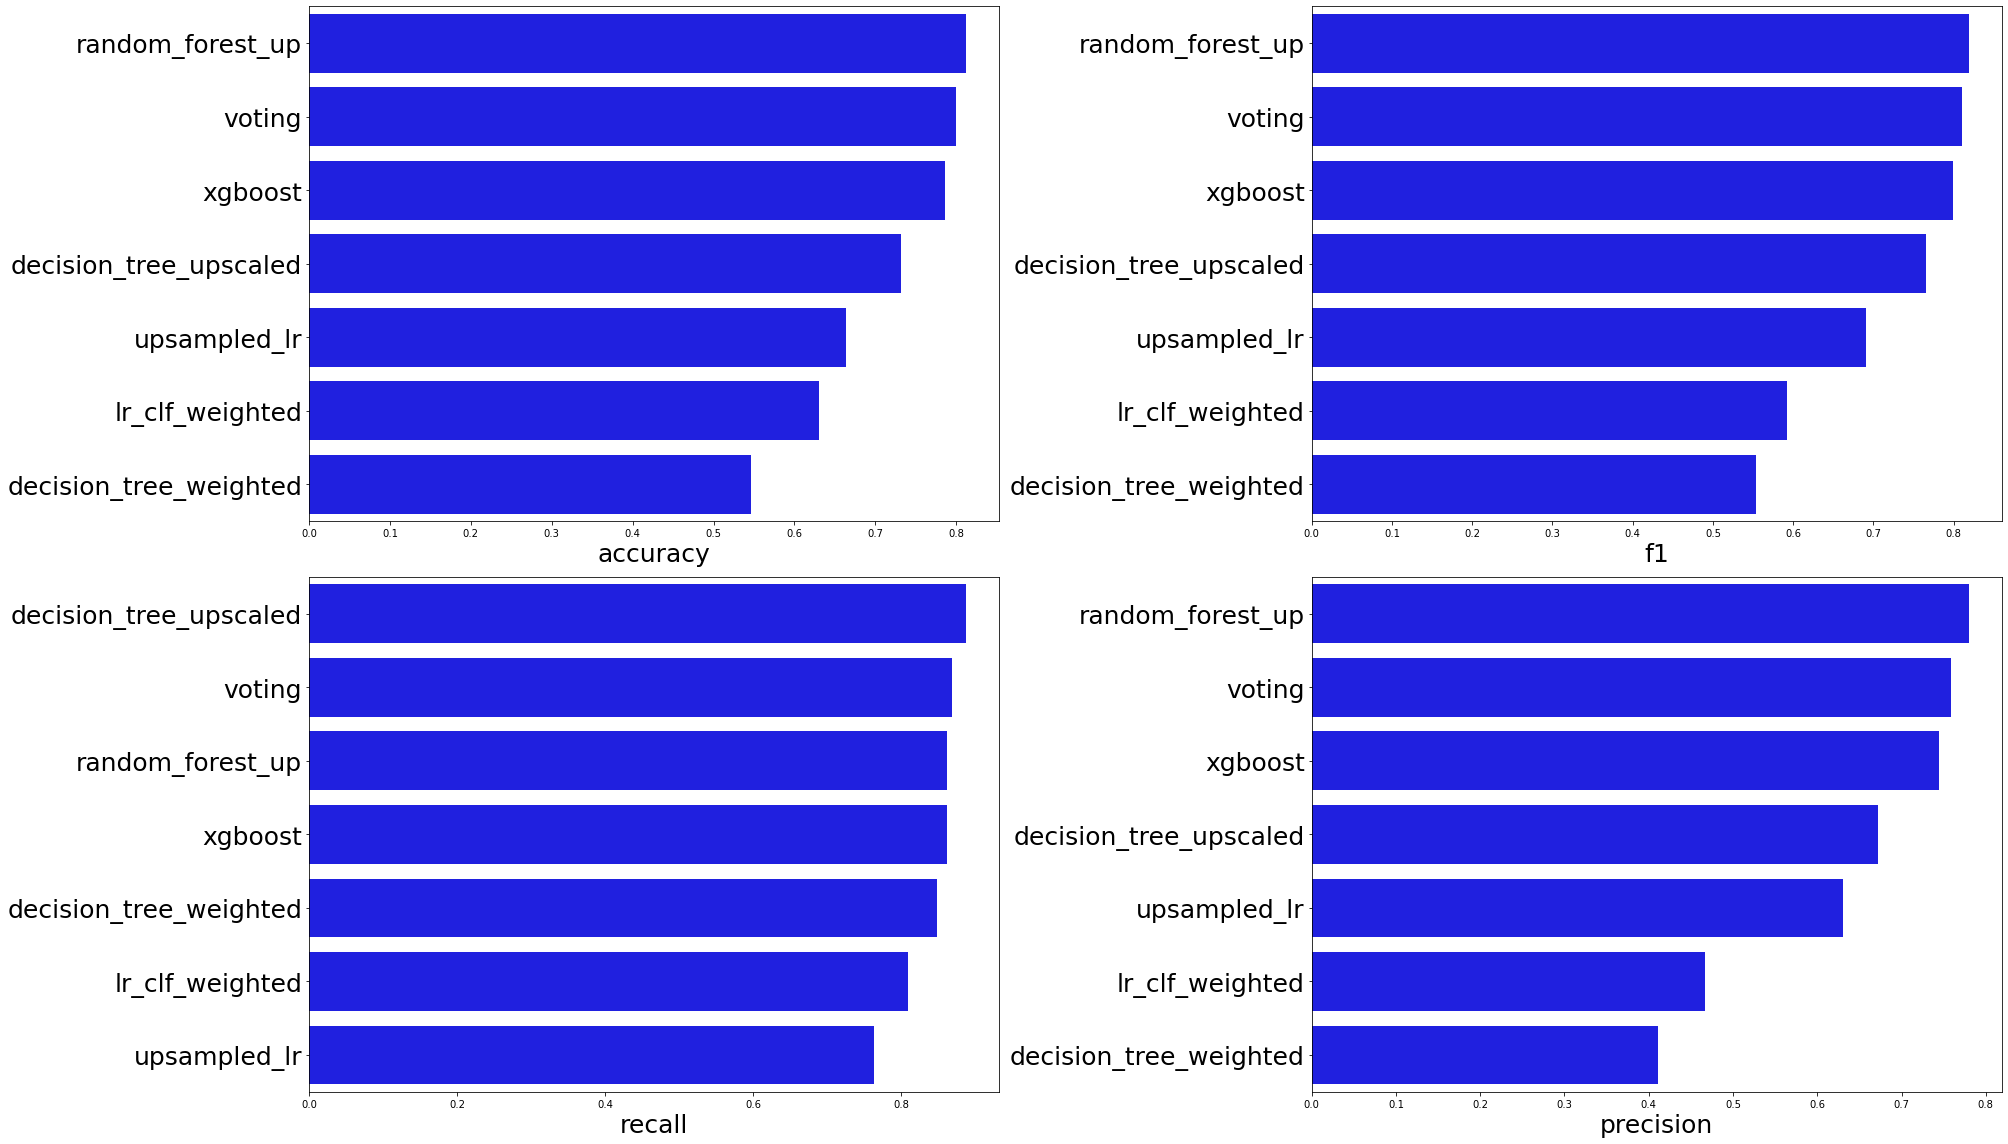

In [76]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(28,16))
for i, col in enumerate(results_df.columns[1:]):
    results_df = results_df.sort_values(by=col, ascending=False)
    sns.barplot(y=results_df.model, x=results_df[col], ax = axes[i//2][i%2], color='blue')
    axes[i//2][i%2].set_yticklabels(results_df.model, size = 25)
    axes[i//2][i%2].set_ylabel("",fontsize=0)
    axes[i//2][i%2].set_xlabel(col ,fontsize=25)

plt.tight_layout()
plt.savefig("pics/model_performance.png")

In [77]:
import pickle
pickle_out = open("forest.pickle","wb")
pickle.dump(grid_forest.best_estimator_, pickle_out)
pickle_out.close()

In [78]:
pickle_out = open("voting.pickle","wb")
pickle.dump(voting_clf, pickle_out)
pickle_out.close()

In [79]:
X_test_up.columns

Index(['danceability', 'energy', 'loudness', 'musical_mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'explicit', 'duration_per_num_sections', 'key__1',
       'key__2', 'key__3', 'key__4', 'key__5', 'key__6', 'key__7', 'key__8',
       'key__9', 'key__10', 'key__11', 'time_sig__1', 'time_sig__3',
       'time_sig__4', 'time_sig__5', 'no_instruments'],
      dtype='object')